In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glacier-datasets/Train/label/Y_output_resized_05_10.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_06_11.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_08_14.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_09_14.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_06_12.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_03_09.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_04_10.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_02_08.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_08_12.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_07_10.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_07_13.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_10_12.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_08_13.tif
/kaggle/input/glacier-datasets/Train/label/Y_output_resized_09_13.tif
/kaggle/input/glacie

**What happens in Conv + ReLU**

Conv(3×3) → produces a linear weighted sum of pixel neighborhood.
Example: z = w1·x1 + w2·x2 + … + b
This is just a linear equation.

ReLU(z) = max(0, z)

If z > 0 → keep it.

If z ≤ 0 → squash it to 0.

🔹 Why does this make it nonlinear?

Imagine the function of one neuron:

Without ReLU: y = ax + b → always a straight line.

With ReLU:

y = ax + b   (for ax+b > 0)
y = 0        (for ax+b ≤ 0)


That’s piecewise linear — the graph is bent at 0.
It’s no longer a single straight line, so it’s nonlinear.

🔹 Why zeroing out some features is useful?

Feature selection

ReLU acts like a filter: it says “only keep activations that are meaningful (positive)”.

Useless/negative signals are discarded → network focuses on informative patterns.

Sparsity

Many activations become zero.

This makes the representation sparse → easier to compute, less overfitting.

Nonlinear decision boundaries

Because parts of the input space get squashed to 0 and others pass through, the network can carve complex shapes in the input space.

That’s how CNNs can separate “cat” vs “dog” images, not just linearly.

In [2]:
# ======================================================
# Install packages (if needed)
# ======================================================
# !pip install tifffile scikit-learn tensorflow tqdm

# ======================================================
# Imports
# ======================================================
import os, glob, re, random
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

# ======================================================
# U-Net architecture in TensorFlow/Keras
# ======================================================
def double_conv(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet(n_channels=5, n_classes=1):
    inputs = layers.Input((None, None, n_channels))

    c1 = double_conv(inputs, 64)
    p1 = layers.MaxPool2D((2, 2))(c1)

    c2 = double_conv(p1, 128)
    p2 = layers.MaxPool2D((2, 2))(c2)

    c3 = double_conv(p2, 256)
    p3 = layers.MaxPool2D((2, 2))(c3)

    c4 = double_conv(p3, 512)
    p4 = layers.MaxPool2D((2, 2))(c4)

    c5 = double_conv(p4, 1024)

    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = double_conv(u6, 512)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = double_conv(u7, 256)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = double_conv(u8, 128)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = double_conv(u9, 64)

    outputs = layers.Conv2D(n_classes, 1, activation=None)(c9)  # logits

    return models.Model(inputs, outputs, name="UNet")

# ======================================================
# Dataset loader
# ======================================================



2025-10-03 13:35:18.378091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759498518.542161      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759498518.593315      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class GlacierDatasetTF:
    def __init__(self, root_dir, ids, augment=True):
        self.root_dir = root_dir
        self.ids = ids
        self.augment = augment
        self.band_map = {
            "Band1": "B2",
            "Band2": "B3",
            "Band3": "B4",
            "Band4": "B6",
            "Band5": "B10",
        }

    def __len__(self):
        return len(self.ids)

    def load_item(self, image_id):
        bands_list = []
        for folder, prefix in self.band_map.items():
            fname = f"{prefix}_{prefix}_masked_{image_id}.tif"
            fpath = os.path.join(self.root_dir, folder, fname)
            arr = tiff.imread(fpath).astype(np.float32)
            if arr.ndim == 3:
                arr = arr[..., 0]
            arr = np.nan_to_num(arr, nan=0.0)
            bands_list.append(arr)

        image = np.stack(bands_list, axis=-1)

        mask_path = os.path.join(self.root_dir, "label", f"Y_output_resized_{image_id}.tif")
        mask = tiff.imread(mask_path).astype(np.float32)
        if mask.ndim == 3:
            mask = mask[..., 0]
        mask = (mask > 0).astype(np.float32)

        # Augmentation
        if self.augment:
            if random.random() < 0.5:
                image = np.flip(image, axis=0)
                mask = np.flip(mask, axis=0)
            if random.random() < 0.5:
                image = np.flip(image, axis=1)
                mask = np.flip(mask, axis=1)
            k = random.randint(0, 3)
            if k:
                image = np.rot90(image, k, axes=(0, 1))
                mask = np.rot90(mask, k, axes=(0, 1))

        # Normalize per channel
        mean = image.mean(axis=(0, 1), keepdims=True)
        std = image.std(axis=(0, 1), keepdims=True) + 1e-7
        image = (image - mean) / std

        return image.astype(np.float32), np.expand_dims(mask.astype(np.float32), -1)

    def get_tf_dataset(self, batch_size=4, shuffle=True):
        def gen():
            for image_id in self.ids:
                img, mask = self.load_item(image_id)
                yield img, mask

        output_types = (tf.float32, tf.float32)
        output_shapes = (
            tf.TensorShape([None, None, 5]),
            tf.TensorShape([None, None, 1])
        )

        ds = tf.data.Dataset.from_generator(gen, output_types=output_types, output_shapes=output_shapes)
        if shuffle:
            ds = ds.shuffle(buffer_size=len(self.ids))
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

# ======================================================
# Utils: Dice loss
# ======================================================
def dice_loss(y_true, y_pred, smooth=1.0):
    y_pred = tf.nn.sigmoid(y_pred)
    y_true = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
    intersection = tf.reduce_sum(y_true * y_pred, axis=1)
    return 1 - tf.reduce_mean((2. * intersection + smooth) /
                              (tf.reduce_sum(y_true, axis=1) + tf.reduce_sum(y_pred, axis=1) + smooth))

# Custom loss = BCE + Dice
def bce_dice_loss(y_true, y_pred):
    bce = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return bce + dice_loss(y_true, y_pred)

# ======================================================
# Training
# ======================================================
def train_tf(train_ds, val_ds, epochs=20, lr=1e-4, out_path="model_tf.h5"):
    model = build_unet(n_channels=5, n_classes=1)
    optimizer = optimizers.Adam(learning_rate=lr)

    best_mcc = -1.0

    for epoch in range(1, epochs + 1):
        # Training
        train_loss = []
        for images, masks in tqdm(train_ds, desc=f"Epoch {epoch}/{epochs} [train]"):
            with tf.GradientTape() as tape:
                logits = model(images, training=True)
                loss = bce_dice_loss(masks, logits)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_loss.append(loss.numpy())

        # Validation
        all_preds, all_trues = [], []
        for images, masks in tqdm(val_ds, desc=f"Epoch {epoch}/{epochs} [val]"):
            logits = model(images, training=False)
            probs = tf.nn.sigmoid(logits).numpy()
            preds = (probs > 0.5).astype(np.uint8)
            trues = masks.numpy().astype(np.uint8)
            for i in range(preds.shape[0]):
                all_preds.append(preds[i].ravel())
                all_trues.append(trues[i].ravel())

        flat_preds = np.concatenate(all_preds)
        flat_trues = np.concatenate(all_trues)
        try:
            mcc = matthews_corrcoef(flat_trues, flat_preds)
        except:
            mcc = 0.0

        print(f"Epoch {epoch} | Train Loss: {np.mean(train_loss):.4f} | Val MCC: {mcc:.4f}")

        if mcc > best_mcc:
            best_mcc = mcc
            model.save(out_path)
            print(f"Saved best model (MCC={best_mcc:.4f}) to {out_path}")

    print("Training finished. Best MCC:", best_mcc)
    return out_path

# ======================================================
# Setup paths
# ======================================================
DATA_ROOT = "/kaggle/input/glacier-datasets/Train"
band1_files = sorted(glob.glob(os.path.join(DATA_ROOT, "Band1", "*.tif")))

def extract_id(path):
    m = re.search(r"masked_(\d+_\d+)\.tif", os.path.basename(path))
    return m.group(1) if m else None

image_ids = [extract_id(f) for f in band1_files]

train_ids, val_ids = train_test_split(image_ids, test_size=0.15, random_state=42)

BATCH_SIZE = 4
NUM_EPOCHS = 20
LR = 1e-4

train_dataset = GlacierDatasetTF(DATA_ROOT, train_ids, augment=False)
val_dataset = GlacierDatasetTF(DATA_ROOT, val_ids, augment=False)

train_ds = train_dataset.get_tf_dataset(batch_size=BATCH_SIZE, shuffle=True)
val_ds = val_dataset.get_tf_dataset(batch_size=BATCH_SIZE, shuffle=False)

print("Train images:", len(train_dataset), "| Val images:", len(val_dataset))

# ======================================================
# Train and save model
# ======================================================
trained_path = train_tf(train_ds, val_ds, epochs=NUM_EPOCHS, lr=LR, out_path="/kaggle/working/model.h5")
print("Final saved model at:", trained_path)

I0000 00:00:1759498529.719630      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Train images: 21 | Val images: 4


Epoch 1/20 [train]: 0it [00:00, ?it/s]I0000 00:00:1759498534.037034      36 cuda_dnn.cc:529] Loaded cuDNN version 90300
Epoch 1/20 [train]: 6it [00:24,  4.11s/it]
Epoch 1/20 [val]: 1it [00:00,  1.03it/s]


Epoch 1 | Train Loss: 1.2715 | Val MCC: 0.3346
Saved best model (MCC=0.3346) to /kaggle/working/model.h5


Epoch 2/20 [train]: 6it [00:06,  1.09s/it]
Epoch 2/20 [val]: 1it [00:00,  2.48it/s]


Epoch 2 | Train Loss: 1.0862 | Val MCC: 0.3651
Saved best model (MCC=0.3651) to /kaggle/working/model.h5


Epoch 3/20 [train]: 6it [00:06,  1.08s/it]
Epoch 3/20 [val]: 1it [00:00,  2.40it/s]


Epoch 3 | Train Loss: 1.0805 | Val MCC: 0.3820
Saved best model (MCC=0.3820) to /kaggle/working/model.h5


Epoch 4/20 [train]: 6it [00:06,  1.09s/it]
Epoch 4/20 [val]: 1it [00:00,  2.52it/s]


Epoch 4 | Train Loss: 0.9608 | Val MCC: 0.3751


Epoch 5/20 [train]: 6it [00:06,  1.08s/it]
Epoch 5/20 [val]: 1it [00:00,  2.53it/s]


Epoch 5 | Train Loss: 0.9604 | Val MCC: 0.3357


Epoch 6/20 [train]: 6it [00:06,  1.07s/it]
Epoch 6/20 [val]: 1it [00:00,  2.47it/s]


Epoch 6 | Train Loss: 0.8459 | Val MCC: 0.3237


Epoch 7/20 [train]: 6it [00:06,  1.07s/it]
Epoch 7/20 [val]: 1it [00:00,  2.50it/s]


Epoch 7 | Train Loss: 0.8209 | Val MCC: 0.3133


Epoch 8/20 [train]: 6it [00:06,  1.07s/it]
Epoch 8/20 [val]: 1it [00:00,  2.62it/s]


Epoch 8 | Train Loss: 0.7848 | Val MCC: 0.3096


Epoch 9/20 [train]: 6it [00:06,  1.07s/it]
Epoch 9/20 [val]: 1it [00:00,  2.62it/s]


Epoch 9 | Train Loss: 0.7453 | Val MCC: 0.2894


Epoch 10/20 [train]: 6it [00:06,  1.07s/it]
Epoch 10/20 [val]: 1it [00:00,  2.62it/s]


Epoch 10 | Train Loss: 0.7234 | Val MCC: 0.2879


Epoch 11/20 [train]: 6it [00:06,  1.08s/it]
Epoch 11/20 [val]: 1it [00:00,  2.53it/s]


Epoch 11 | Train Loss: 0.7620 | Val MCC: 0.3267


Epoch 12/20 [train]: 6it [00:06,  1.07s/it]
Epoch 12/20 [val]: 1it [00:00,  2.53it/s]


Epoch 12 | Train Loss: 0.6835 | Val MCC: 0.3024


Epoch 13/20 [train]: 6it [00:06,  1.07s/it]
Epoch 13/20 [val]: 1it [00:00,  2.54it/s]


Epoch 13 | Train Loss: 0.6649 | Val MCC: 0.3081


Epoch 14/20 [train]: 6it [00:06,  1.07s/it]
Epoch 14/20 [val]: 1it [00:00,  2.56it/s]


Epoch 14 | Train Loss: 0.7188 | Val MCC: 0.3155


Epoch 15/20 [train]: 6it [00:06,  1.07s/it]
Epoch 15/20 [val]: 1it [00:00,  2.64it/s]


Epoch 15 | Train Loss: 0.6336 | Val MCC: 0.3233


Epoch 16/20 [train]: 6it [00:06,  1.07s/it]
Epoch 16/20 [val]: 1it [00:00,  2.61it/s]


Epoch 16 | Train Loss: 0.6396 | Val MCC: 0.3418


Epoch 17/20 [train]: 6it [00:06,  1.07s/it]
Epoch 17/20 [val]: 1it [00:00,  2.51it/s]


Epoch 17 | Train Loss: 0.5720 | Val MCC: 0.3155


Epoch 18/20 [train]: 6it [00:06,  1.08s/it]
Epoch 18/20 [val]: 1it [00:00,  2.54it/s]


Epoch 18 | Train Loss: 0.5486 | Val MCC: 0.3202


Epoch 19/20 [train]: 6it [00:06,  1.06s/it]
Epoch 19/20 [val]: 1it [00:00,  2.59it/s]


Epoch 19 | Train Loss: 0.5858 | Val MCC: 0.3243


Epoch 20/20 [train]: 6it [00:06,  1.07s/it]
Epoch 20/20 [val]: 1it [00:00,  2.54it/s]


Epoch 20 | Train Loss: 0.5109 | Val MCC: 0.3354
Training finished. Best MCC: 0.381989916400425
Final saved model at: /kaggle/working/model.h5


In [ ]:
# # ======================================================
# # Cell 1 — (optional) install packages if missing
# # ======================================================
# # pip install tifffile tqdm scikit-learn

# # ======================================================
# # Cell 2 — imports
# # ======================================================
# import os, glob, re, random
# import numpy as np
# import tifffile as tiff
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import matthews_corrcoef

# # ======================================================
# # U-Net architecture
# # ======================================================
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#     def forward(self, x):
#         return self.double_conv(x)

# class UNet(nn.Module):
#     def __init__(self, n_channels=5, n_classes=1):
#         super().__init__()
#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
#         self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
#         self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
#         self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

#         self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.conv1 = DoubleConv(1024, 512)
#         self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.conv2 = DoubleConv(512, 256)
#         self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.conv3 = DoubleConv(256, 128)
#         self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.conv4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)

#         x = self.up1(x5)
#         x = torch.cat([x, x4], dim=1)
#         x = self.conv1(x)
#         x = self.up2(x)
#         x = torch.cat([x, x3], dim=1)
#         x = self.conv2(x)
#         x = self.up3(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.conv3(x)
#         x = self.up4(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.conv4(x)
#         return self.outc(x)

# # ======================================================
# # Dataset class (with stronger augmentations)
# # ======================================================
# class GlacierDataset(Dataset):
#     def __init__(self, root_dir, image_ids, augment=False):
#         self.root_dir = root_dir
#         self.ids = image_ids
#         self.augment = augment
#         self.band_map = {
#             "Band1": "B2",
#             "Band2": "B3",
#             "Band3": "B4",
#             "Band4": "B6",
#             "Band5": "B10",
#         }
        
#     def __len__(self):
#         return len(self.ids)

#     def __getitem__(self, idx):
#         image_id = self.ids[idx]
#         bands_list = []

#         for folder, prefix in self.band_map.items():
#             fname = f"{prefix}_{prefix}_masked_{image_id}.tif"
#             fpath = os.path.join(self.root_dir, folder, fname)
#             if not os.path.exists(fpath):
#                 raise FileNotFoundError(f"Missing file: {fpath}")
#             arr = tiff.imread(fpath).astype(np.float32)
#             if arr.ndim == 3:
#                 arr = arr[..., 0]
#             arr = np.nan_to_num(arr, nan=0.0)
#             bands_list.append(arr)

#         image = np.stack(bands_list, axis=-1)

#         # mask
#         mask_path = os.path.join(self.root_dir, "label", f"Y_output_resized_{image_id}.tif")
#         mask = tiff.imread(mask_path).astype(np.float32)
#         if mask.ndim == 3:
#             mask = mask[..., 0]
#         mask = (mask > 0).astype(np.float32)

#         # augmentation
#         if self.augment:
#             if random.random() < 0.5:
#                 image = np.flip(image, axis=0)
#                 mask = np.flip(mask, axis=0)
#             if random.random() < 0.5:
#                 image = np.flip(image, axis=1)
#                 mask = np.flip(mask, axis=1)
#             k = random.randint(0, 3)
#             if k:
#                 image = np.rot90(image, k, axes=(0, 1))
#                 mask = np.rot90(mask, k, axes=(0, 1))

#             # extra augmentations
#             if random.random() < 0.3:
#                 factor = 0.9 + 0.2 * random.random()  # brightness
#                 image = image * factor
#             if random.random() < 0.3:
#                 noise = np.random.normal(0, 0.05, image.shape)  # gaussian noise
#                 image = image + noise

#         # normalize per-channel
#         mean = image.mean(axis=(0, 1), keepdims=True)
#         std = image.std(axis=(0, 1), keepdims=True) + 1e-7
#         image = (image - mean) / std

#         # to tensors
#         image = torch.from_numpy(image.transpose(2, 0, 1).copy()).float()
#         mask = torch.from_numpy(mask.copy()).unsqueeze(0).float()
#         return image, mask

# # ======================================================
# # Utils
# # ======================================================
# def dice_loss_logits(preds_logits, targets, smooth=1.0):
#     preds = torch.sigmoid(preds_logits)
#     preds_flat = preds.view(preds.size(0), -1)
#     targets_flat = targets.view(targets.size(0), -1)
#     intersection = (preds_flat * targets_flat).sum(1)
#     return 1 - ((2. * intersection + smooth) / (preds_flat.sum(1) + targets_flat.sum(1) + smooth)).mean()

# def focal_loss_logits(preds_logits, targets, alpha=0.8, gamma=2.0):
#     bce = F.binary_cross_entropy_with_logits(preds_logits, targets, reduction='none')
#     probs = torch.sigmoid(preds_logits)
#     pt = torch.where(targets == 1, probs, 1 - probs)
#     focal = alpha * (1 - pt) ** gamma * bce
#     return focal.mean()

# def extract_id(path):
#     m = re.search(r"masked_(\d+_\d+)\.tif", os.path.basename(path))
#     return m.group(1) if m else None

# # ======================================================
# # Training loop
# # ======================================================
# def train(train_loader, val_loader, device, epochs=20, lr=1e-4, out_path="/kaggle/working/model.pth"):
#     model = UNet(n_channels=5, n_classes=1).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     best_mcc = -1.0

#     for epoch in range(1, epochs + 1):
#         model.train()
#         train_loss = 0.0
#         pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]")
#         for images, masks in pbar:
#             images = images.to(device)
#             masks = masks.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)  # logits

#             bce = F.binary_cross_entropy_with_logits(outputs, masks)
#             dice = dice_loss_logits(outputs, masks)
#             focal = focal_loss_logits(outputs, masks)

#             loss = 0.5 * bce + 0.5 * dice + 0.5 * focal
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             pbar.set_postfix({'loss': train_loss / (pbar.n + 1)})

#         # Validation
#         model.eval()
#         all_preds, all_trues = [], []
#         with torch.no_grad():
#             for images, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [val]"):
#                 images = images.to(device)
#                 masks = masks.to(device)
#                 outputs = model(images)
#                 probs = torch.sigmoid(outputs).cpu().numpy()
#                 preds = (probs > 0.5).astype(np.uint8)
#                 trues = masks.cpu().numpy().astype(np.uint8)

#                 N = preds.shape[0]
#                 preds = preds.reshape(N, -1)
#                 trues = trues.reshape(N, -1)
#                 for i in range(N):
#                     all_preds.append(preds[i])
#                     all_trues.append(trues[i])

#         flat_preds = np.concatenate(all_preds).ravel()
#         flat_trues = np.concatenate(all_trues).ravel()
#         try:
#             mcc = matthews_corrcoef(flat_trues, flat_preds)
#         except Exception:
#             mcc = 0.0

#         print(f"Epoch {epoch} | Train Loss: {train_loss/len(train_loader):.4f} | Val MCC: {mcc:.4f}")

#         if mcc > best_mcc:
#             best_mcc = mcc
#             torch.save(model.state_dict(), out_path)
#             print(f"Saved best model (MCC={best_mcc:.4f}) to {out_path}")

#     print("Training finished. Best MCC:", best_mcc)
#     return out_path

# # ======================================================
# # Setup paths & loaders
# # ======================================================
# DATA_ROOT = "/kaggle/input/glacier-dataset/Train"

# band1_files = sorted(glob.glob(os.path.join(DATA_ROOT, "Band1", "*.tif")))
# image_ids = [extract_id(f) for f in band1_files]

# train_ids, val_ids = train_test_split(image_ids, test_size=0.15, random_state=42)

# BATCH_SIZE = 4
# NUM_EPOCHS = 40  # increased epochs
# LR = 1e-4

# train_dataset = GlacierDataset(DATA_ROOT, train_ids, augment=True)   # enable augmentations
# val_dataset = GlacierDataset(DATA_ROOT, val_ids, augment=False)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device:", device, "| Train images:", len(train_dataset), "| Val images:", len(val_dataset))

# # ======================================================
# # Train and save
# # ======================================================
# model_output_path = "/kaggle/working/model.pth"
# trained_path = train(train_loader, val_loader, device, epochs=NUM_EPOCHS, lr=LR, out_path=model_output_path)
# print("Final saved model at:", trained_path)


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ------------------------
# Evaluation Function
# ------------------------
def evaluate_model_tf(model, dataset, threshold=0.5):
    all_labels = []
    all_preds = []

    for images, labels in dataset:
        # Forward pass
        logits = model(images, training=False)         # [B, H, W, 1]
        probs = tf.nn.sigmoid(logits).numpy()          # convert logits → probs
        preds = (probs > threshold).astype(np.uint8)   # binary mask

        # Flatten everything for sklearn metrics
        all_labels.extend(labels.numpy().ravel().tolist())
        all_preds.extend(preds.ravel().tolist())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, zero_division=0)

    print("📊 Evaluation Results:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

    return acc, prec, rec, f1, cm, report


# ------------------------
# Load Best Model
# ------------------------
# UNet should be defined in your notebook (same as training)
from tensorflow.keras.models import load_model

# When saving, you should wrap custom loss functions with 'compile=False'
model = tf.keras.models.load_model("/kaggle/working/model.h5", compile=False)

# ------------------------
# Run Evaluation
# ------------------------
acc, prec, rec, f1, cm, report = evaluate_model_tf(model, val_ds)


📊 Evaluation Results:
Accuracy : 0.6862
Precision: 0.4149
Recall   : 0.7949
F1-score : 0.5452

Confusion Matrix:
[[522332 278130]
 [ 50890 197224]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76    800462
         1.0       0.41      0.79      0.55    248114

    accuracy                           0.69   1048576
   macro avg       0.66      0.72      0.65   1048576
weighted avg       0.79      0.69      0.71   1048576



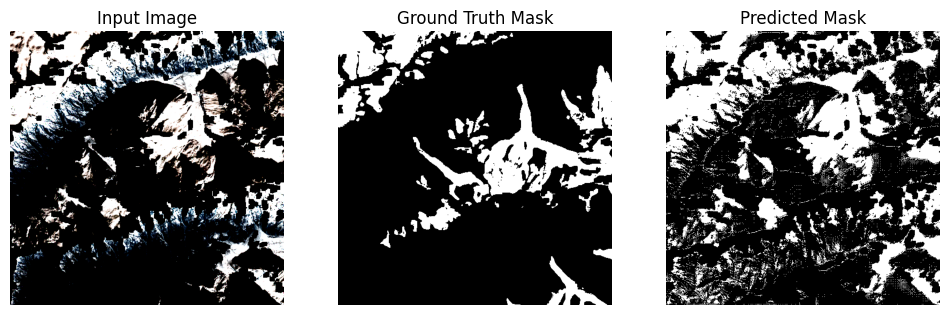

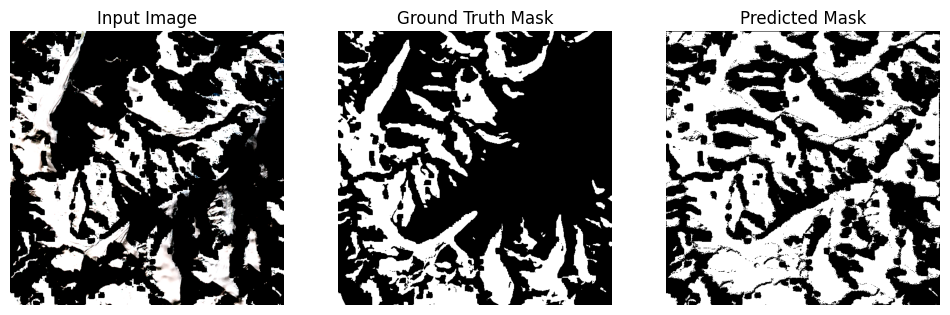

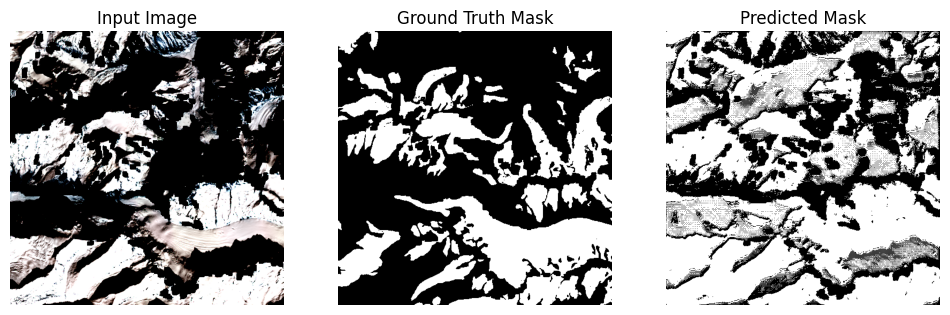

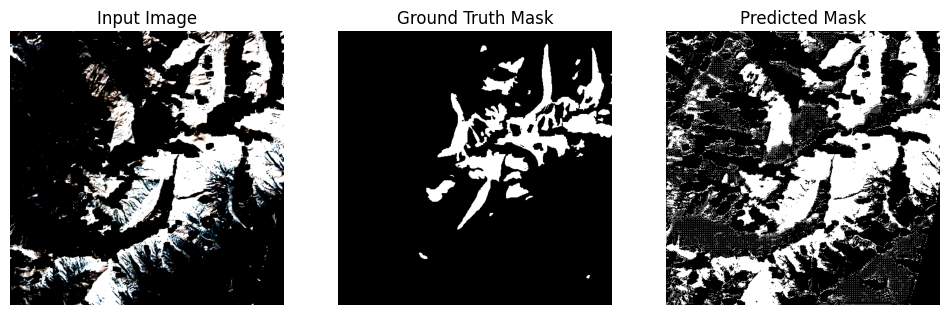

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def visualize_predictions_tf(model, dataset, num_samples=5):
    """
    Visualize input image, ground truth mask, and predicted mask
    for a TensorFlow / Keras model.

    Args:
        model: trained Keras/TensorFlow model
        dataset: tf.data.Dataset yielding (image, mask) pairs
        num_samples: number of samples to visualize
    """
    images_shown = 0

    for batch in dataset:
        images, masks = batch
        # Ensure numpy arrays
        images_np = images.numpy() if isinstance(images, tf.Tensor) else images
        masks_np = masks.numpy() if isinstance(masks, tf.Tensor) else masks

        # Predict
        preds = model(images, training=False)
        preds = tf.nn.sigmoid(preds).numpy()  # convert logits → probs
        preds = (preds > 0.5).astype(np.uint8)  # binary mask

        batch_size = images_np.shape[0]
        for i in range(batch_size):
            if images_shown >= num_samples:
                return

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))

            # Input image: pick first 3 channels if more than 3
            if images_np.shape[-1] >= 3:
                axs[0].imshow(images_np[i, :, :, :3])
            else:
                axs[0].imshow(images_np[i, :, :, 0], cmap='gray')
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            # Ground truth mask
            axs[1].imshow(masks_np[i, :, :, 0], cmap='gray')
            axs[1].set_title("Ground Truth Mask")
            axs[1].axis("off")

            # Predicted mask
            axs[2].imshow(preds[i, :, :, 0], cmap='gray')
            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")

            plt.show()
            images_shown += 1

# ---------------------------
# Load model
# ---------------------------
model = build_unet(n_channels=5, n_classes=1)
model.load_weights("/kaggle/working/model.h5")  # path to your trained model

# ---------------------------
# Visualize predictions
# ---------------------------
visualize_predictions_tf(model, val_ds, num_samples=5)


In [9]:
import numpy as np
import tifffile as tiff
from sklearn.metrics import confusion_matrix, matthews_corrcoef


In [10]:
# ======================================================
# Install packages if needed
# ======================================================
# !pip install tifffile tensorflow numpy matplotlib

# ======================================================
# Imports
# ======================================================
import os
import glob
import re
import numpy as np
import tensorflow as tf
import tifffile as tiff
from tensorflow.keras import layers, models

# ======================================================
# U-Net architecture in TensorFlow/Keras
# ======================================================
def double_conv(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet(n_channels=5, n_classes=1):
    inputs = layers.Input((None, None, n_channels))
    
    # Encoder
    c1 = double_conv(inputs, 64)
    p1 = layers.MaxPool2D(2)(c1)
    c2 = double_conv(p1, 128)
    p2 = layers.MaxPool2D(2)(c2)
    c3 = double_conv(p2, 256)
    p3 = layers.MaxPool2D(2)(c3)
    c4 = double_conv(p3, 512)
    p4 = layers.MaxPool2D(2)(c4)
    c5 = double_conv(p4, 1024)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = double_conv(u6, 512)
    
    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = double_conv(u7, 256)
    
    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = double_conv(u8, 128)
    
    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = double_conv(u9, 64)
    
    outputs = layers.Conv2D(n_classes, 1, activation=None)(c9)
    
    return models.Model(inputs, outputs, name="UNet")

# ======================================================
# Helper functions
# ======================================================
def extract_image_id(filename):
    m = re.search(r"masked_(\d+_\d+)\.tif", os.path.basename(filename))
    return m.group(1) if m else None

def load_and_preprocess_image_tf(imagepath, image_id):
    band_map = {
        "Band1": "B2",
        "Band2": "B3",
        "Band3": "B4",
        "Band4": "B6",
        "Band5": "B10",
    }
    bands = []
    for folder, prefix in band_map.items():
        fname = f"{prefix}_{prefix}_masked_{image_id}.tif"
        fpath = os.path.join(imagepath, folder, fname)
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"Missing file: {fpath}")
        arr = tiff.imread(fpath).astype(np.float32)
        if arr.ndim == 3:
            arr = arr[..., 0]
        arr = np.nan_to_num(arr, nan=0.0)
        bands.append(arr)
    stacked_image = np.stack(bands, axis=-1)
    # Normalize per-channel
    mean = stacked_image.mean(axis=(0,1), keepdims=True)
    std = stacked_image.std(axis=(0,1), keepdims=True) + 1e-7
    stacked_image = (stacked_image - mean) / std
    return stacked_image.astype(np.float32)

def predict_mask_tf(model, image_numpy):
    """
    Predict mask for one image [H,W,5].
    """
    input_tensor = np.expand_dims(image_numpy, axis=0)  # [1,H,W,5]
    logits = model.predict(input_tensor, verbose=0)
    probs = tf.nn.sigmoid(logits).numpy()
    mask = (probs > 0.5).astype(np.uint8)[0, ..., 0]  # [H,W]
    return mask

# ======================================================
# Mask generation
# ======================================================
def mask_generation_tf(imagepath, out_dir, model_path):
    os.makedirs(out_dir, exist_ok=True)
    
    # Load model
    model = build_unet(n_channels=5, n_classes=1)
    model.load_weights(model_path)
    print("Model loaded successfully.")
    
    # Use Band1 folder to get IDs
    band1_path = os.path.join(imagepath, "Band1")
    image_files = glob.glob(os.path.join(band1_path, "*.tif"))
    image_ids = [extract_image_id(f) for f in image_files if extract_image_id(f) is not None]
    print(f"Found {len(image_ids)} images to process.")
    
    for idx, image_id in enumerate(image_ids):
        try:
            print(f"[{idx+1}/{len(image_ids)}] Processing: {image_id}")
            img = load_and_preprocess_image_tf(imagepath, image_id)
            mask = predict_mask_tf(model, img)
            out_path = os.path.join(out_dir, f"pred_mask_{image_id}.tif")
            tiff.imwrite(out_path, mask*255)
        except Exception as e:
            print(f"Error processing {image_id}: {e}")
            fallback_mask = np.zeros((256,256), dtype=np.uint8)
            tiff.imwrite(os.path.join(out_dir, f"pred_mask_{image_id}.tif"), fallback_mask)

# ======================================================
# Example usage
# ======================================================
IMAGE_ROOT = "/kaggle/input/glacier-datasets/Train"
OUT_DIR = "/kaggle/working/pred_masks"
MODEL_PATH = "/kaggle/working/model.h5"

mask_generation_tf(IMAGE_ROOT, OUT_DIR, MODEL_PATH)

print("Mask generation completed.")


Model loaded successfully.
Found 25 images to process.
[1/25] Processing: 04_10


I0000 00:00:1759498861.830822      95 service.cc:148] XLA service 0x7af8040031c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759498861.831732      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759498866.141525      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[2/25] Processing: 02_08
[3/25] Processing: 02_07
[4/25] Processing: 06_11
[5/25] Processing: 05_08
[6/25] Processing: 07_11
[7/25] Processing: 03_09
[8/25] Processing: 05_10
[9/25] Processing: 06_09
[10/25] Processing: 03_11
[11/25] Processing: 07_10
[12/25] Processing: 08_13
[13/25] Processing: 04_08
[14/25] Processing: 10_12
[15/25] Processing: 07_13
[16/25] Processing: 09_13
[17/25] Processing: 12_12
[18/25] Processing: 08_12
[19/25] Processing: 03_07
[20/25] Processing: 09_14
[21/25] Processing: 11_13
[22/25] Processing: 04_09
[23/25] Processing: 08_14
[24/25] Processing: 05_09
[25/25] Processing: 06_12
Mask generation completed.


In [11]:
import os
import numpy as np
import tifffile as tiff
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# -------------------------------
# Helper: extract image ID
# -------------------------------
def extract_id(fname):
    """
    Extract ID like '02_07' from 'pred_mask_02_07.tif'
    """
    import re
    m = re.search(r"pred_mask_(\d+_\d+)\.tif", fname)
    return m.group(1) if m else None

# -------------------------------
# Evaluate masks
# -------------------------------
def evaluate_masks_tf(gt_dir, pred_dir):
    ids = []
    metrics = []  # [accuracy, iou, dice, mcc]

    for fname in os.listdir(pred_dir):
        image_id = extract_id(fname)
        if image_id is None:
            continue
        
        pred_path = os.path.join(pred_dir, fname)
        gt_name = f"Y_output_resized_{image_id}.tif"
        gt_path = os.path.join(gt_dir, gt_name)

        if not os.path.exists(gt_path):
            print(f"⚠️ Ground truth missing for {image_id}")
            continue

        # Load masks
        pred = tiff.imread(pred_path)
        gt = tiff.imread(gt_path)

        # Binarize masks
        pred = (pred > 127).astype(np.uint8).flatten()
        gt = (gt > 127).astype(np.uint8).flatten()

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(gt, pred, labels=[0,1]).ravel()

        # Metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        iou = tp / (tp + fp + fn + 1e-7)
        dice = 2*tp / (2*tp + fp + fn + 1e-7)
        mcc = matthews_corrcoef(gt, pred)

        metrics.append([accuracy, iou, dice, mcc])
        ids.append(image_id)

    # Print results per image
    print(f"{'ID':<10}{'Acc':<10}{'IoU':<10}{'Dice':<10}{'MCC':<10}")
    for i, m in zip(ids, metrics):
        print(f"{i:<10}{m[0]:.4f}   {m[1]:.4f}   {m[2]:.4f}   {m[3]:.4f}")

    # Print mean scores
    if metrics:
        metrics = np.array(metrics)
        avg = metrics.mean(axis=0)
        print("\nAVERAGE:")
        print(f"Accuracy={avg[0]:.4f}, IoU={avg[1]:.4f}, Dice={avg[2]:.4f}, MCC={avg[3]:.4f}")

# ======================================================
# Example usage
# ======================================================
GT_DIR = "/kaggle/input/glacier-datasets/Train/label"
PRED_DIR = "/kaggle/working/pred_masks"

evaluate_masks_tf(GT_DIR, PRED_DIR)


ID        Acc       IoU       Dice      MCC       
02_07     0.6192   0.4349   0.6062   0.3276
08_13     0.7688   0.6679   0.8009   0.5456
07_10     0.6895   0.2561   0.4078   0.2699
09_14     0.8781   0.5372   0.6990   0.6344
05_09     0.7115   0.5591   0.7172   0.4975
09_13     0.5778   0.3136   0.4775   0.3499
08_14     0.8611   0.4411   0.6121   0.5396
08_12     0.5506   0.3323   0.4988   0.1748
12_12     0.6277   0.2000   0.3333   0.1295
06_11     0.5916   0.3412   0.5088   0.3287
07_11     0.5548   0.3103   0.4736   0.2982
03_11     0.4988   0.2460   0.3949   0.0940
04_10     0.7759   0.6809   0.8101   0.5539
04_09     0.6186   0.4688   0.6383   0.2624
06_09     0.7106   0.5679   0.7244   0.4741
03_09     0.6227   0.4596   0.6298   0.3032
05_10     0.6365   0.5038   0.6700   0.2885
07_13     0.7267   0.5028   0.6691   0.5226
05_08     0.6965   0.2601   0.4128   0.2418
10_12     0.5471   0.2006   0.3341   0.2457
03_07     0.4991   0.1281   0.2270   0.0038
06_12     0.7751   0.6385

In [ ]:
# import os

# dir_path = "/kaggle/working/pred_masks"

# if os.path.exists(dir_path) and os.path.isdir(dir_path):
#     for filename in os.listdir(dir_path):
#         file_path = os.path.join(dir_path, filename)
#         if os.path.isfile(file_path):
#             os.remove(file_path)  # remove file
#     print(f"All files in {dir_path} have been removed")
# else:
#     print(f"{dir_path} does not exist or is not a directory")

